# Groundwater Concentration Data Cleaning and Visualization #

## December 2023 ##

In [ ]:
require(readxl)
require(lubridate)
require(dplyr)
require(tidyr)
require(janitor)
require(ggplot2)
require(writexl)

**Import datasets (hydrocarbon constituent concentrations, sulfate concentrations, sulfate injections):**

In [ ]:
Data <- read_excel("~/Library/Mobile Documents/com~apple~CloudDocs/DATA NOTES/Data Files/Sample Data PHC (2).xlsx")
head(Data)

In [ ]:
sulfate_data <- read_excel("~/Library/Mobile Documents/com~apple~CloudDocs/DATA NOTES/Data Files/Sample Data Sulfate (1).xlsx")
head(sulfate_data)

In [ ]:
sulfate_injections_data <- read_excel("~/Library/Mobile Documents/com~apple~CloudDocs/DATA NOTES/Data Files/sulfate injections dataset (1).xlsx")
head(sulfate_injections_data)

### Data Cleaning (hydrocarbon constituent concentrations): ###

Format class: 

In [ ]:
Data$Date <- as.Date(Data$`Date Sampled`)
Data$MW <- as.factor(Data$`Monitoring Well`)

Write function to create new column indicating whether the constituent was detected (1) or not detected (0).

In [ ]:
detcol <- function(x){
  ifelse(grepl("ND", x), 0, 1)}

Write function to remove "ND"s from the dataframe and round each concentration result to 5 decimal places:

In [ ]:
cleancols <- function(c){
  gsub("ND", "", c) %>% as.numeric(c, na.rm = FALSE, 5) %>%
    round(5)}


*Clean and format Data for compatability with ProUCL statistical software:*

Create detections column for each constituent: 

In [ ]:
Data$GRO_detections <- detcol(Data$GRO)
Data$DRO_detections <- detcol(Data$DRO)
Data$Benzene_detections <- detcol(Data$Benzene)
Data$Toluene_detections <- detcol(Data$Toluene)
Data$Ethylbenzene_detections <- detcol(Data$Ethylbenzene)
Data$Total_xylenes_detections <- detcol(Data$`Total Xylenes`)

Remove "ND"s and round results:

In [21]:
Data$GRO <- cleancols(Data$GRO)
Data$DRO <- cleancols(Data$DRO)
Data$Benzene <- cleancols(Data$Benzene)
Data$Toluene <- cleancols(Data$Toluene)
Data$Ethylbenzene <- cleancols(Data$Ethylbenzene)
Data$`Total Xylenes` <- cleancols(Data$`Total Xylenes`)

In [22]:
Data$GRO <- cleancols(Data$GRO)
Data$DRO <- cleancols(Data$DRO)
Data$Benzene <- cleancols(Data$Benzene)
Data$Toluene <- cleancols(Data$Toluene)
Data$Ethylbenzene <- cleancols(Data$Ethylbenzene)
Data$`Total Xylenes` <- cleancols(Data$`Total Xylenes`)

Filter to remove duplicate samples, keeping only the highest result:

In [23]:
Data <- Data %>% group_by(MW, Date) %>% filter(GRO == max(GRO)) %>% 
  filter(Benzene == max(Benzene)) %>% filter(Toluene == max(Toluene)) %>% filter(Ethylbenzene == max(Ethylbenzene)) %>%
  filter(`Total Xylenes` == max(`Total Xylenes`))

Calculate total hydrocarbons in new column:

In [24]:
Data$total_hydrocarbons <- as.numeric(Data$GRO + Data$DRO + Data$Benzene + Data$Toluene + 
                                        Data$Ethylbenzene + Data$`Total Xylenes`)

Organize columns and write cleaned Data dataframe to excel:

In [25]:
Data2 <- Data[,c(1,16,3,18,5,19,7,20,9,21,11,22,13,23,24)]
write_xlsx(Data2, "Cleaned Data")

*Cleaning, summarizing and visualizing sulfate concentration and injections data:*

Clean sulfate_injections_data, format class:

In [28]:
sulfate_injections_data <- clean_names(sulfate_injections_data)
sulfate_injections_data$year <- ymd(sulfate_injections_data$year, truncated = 2L) #convert to date
sulfate_injections_data$MW <- as.factor(sulfate_injections_data$well_id_injection_type)

Extract and format injection and push-pull dates from sulfate_injections_data for use in ggplot:

In [29]:
injdates <- sulfate_injections_data %>% filter(type %in% c("Sulfate injection"))
injdates$type <- as.factor(injdates$type)
injdatesonly <- as.data.frame(injdates$year)
injdatesonly <- as.data.frame(injdates$year) %>% mutate(inj_date = injdates$year)
pushpulldates <- sulfate_injections_data %>% filter(type %in% c("Push-pull"))
pushpulldates$type <- as.factor(pushpulldates$type)
pushpulldatesonly <- as.data.frame(pushpulldates$year)
pushpulldatesonly <- as.data.frame(pushpulldates$year) %>% mutate(push_date = pushpulldates$year)

Format sulfate_data column class:

In [ ]:
sulfate_data$Date <- as.Date(as.numeric(as.character(sulfate_data$Date)), origin = "1899-12-30")
sulfate_data$Sulfate <- as.numeric(sulfate_data$Sulfate)
sulfate_data$MW <- as.factor(sulfate_data$`Monitoring Well`)

Filter sulfate_data to remove duplicate samples, keeping only the highest result; and 
remove data from Monitoring Well "N" which is not considered to have independent concentration results. 

In [31]:
sulfate_data2 <- sulfate_data %>% group_by(MW, Date) %>% filter(Sulfate == max(Sulfate)) %>% 
  filter(!MW %in% "N")

*Calculate summary statistics:*

Calculate mean sitewide sulfate concentrations by year:

In [33]:
sulfatemeans <- sulfate_data2 %>% group_by(year = floor_date(Date, "year")) %>%
  summarize(meansulfate = mean(Sulfate))

Calculate yearly mean sulfate concentrations by well:

In [ ]:
sulfatemeansbywell <- sulfate_data2 %>% group_by(MW, year = floor_date(Date, "year")) %>%
  summarize(meansulfate = mean(Sulfate))

Calculate sitewide baseline (pre-2012) sulfate concentrations:

In [35]:
meansulfatebaseline <- sulfate_data2 %>% filter(Date < '2012-01-01')
meansulfatebaseline <- mean(meansulfatebaseline$Sulfate)

*Create time-series visualizations of Data by Monitoring Well:*

Total petroleum hydrocarbons (TPH) at all wells:

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


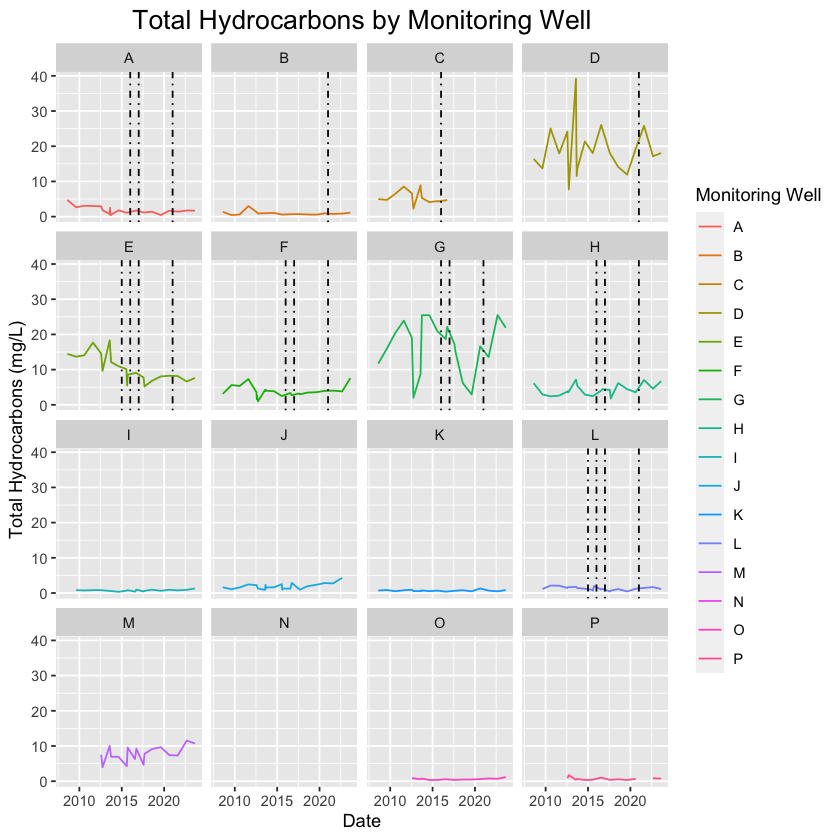

In [41]:
ggplot(Data, aes(Date, total_hydrocarbons, color = MW)) +
  geom_line(na.rm = TRUE) +
  xlim(as.Date(c('1/1/2008', '9/9/2023'), format="%d/%m/%Y")) +
  geom_vline(aes(xintercept=as.numeric(year), color = "Sulfate Injection"),
             data = sulfate_injections_data %>% filter(type == "Sulfate injection"), linetype=4, color = "black") +
  facet_wrap(~ MW) +
  theme(legend.position = "right", plot.title = element_text(size = 16, hjust = 0.5)) +
  labs(color = "Monitoring Well") +
  ggtitle("Total Hydrocarbons by Monitoring Well") + 
  ylab("Total Hydrocarbons (mg/L)") 


TPH by injection well only:

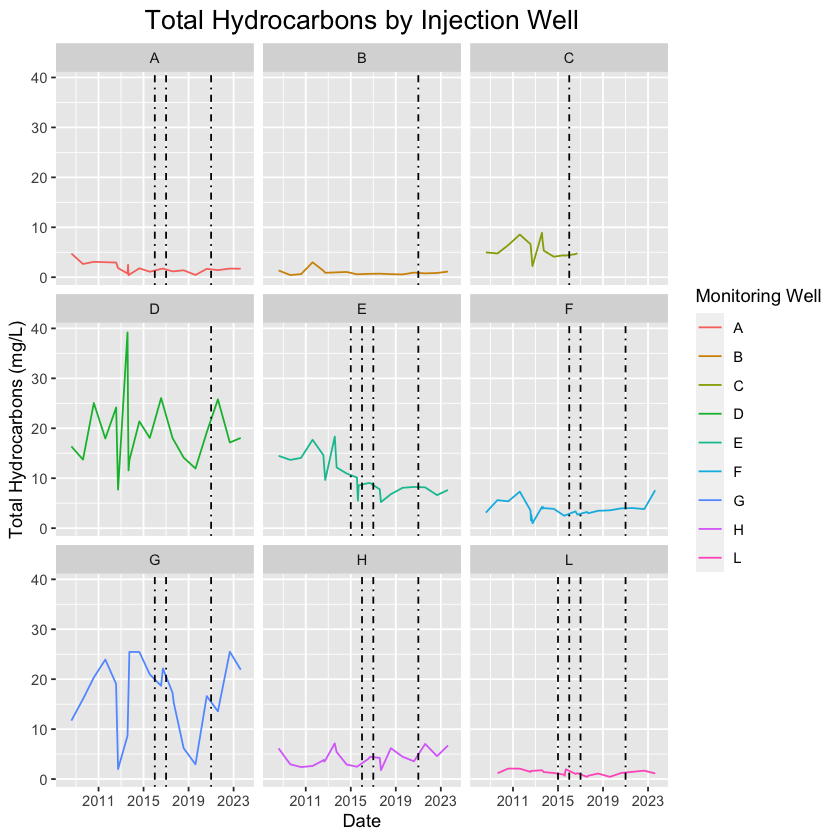

In [40]:
inj <- Data %>% group_by(MW) %>% group_by(Date) %>% filter(MW %in% c("A","B","C","D","E","F","G","H","L"))

ggplot(inj, aes(Date, total_hydrocarbons, color = MW)) +
  geom_line(na.rm = TRUE) +
  geom_vline(aes(xintercept=as.numeric(year), color = "Sulfate Injection"),
             data = sulfate_injections_data %>% filter(type == "Sulfate injection"), linetype=4, color = "black") +
  facet_wrap(~ MW) +
  theme(legend.position = "right", plot.title = element_text(size = 16, hjust = 0.5)) +
  labs(color = "Monitoring Well") +
  ggtitle("Total Hydrocarbons by Injection Well") + 
  ylab("Total Hydrocarbons (mg/L)") +
  scale_x_date(date_breaks = "4 years", date_labels = "%Y", 
               limits = as.Date(c("2008-01-01", "2024-01-01")))

Sulfate concentrations by Injection Well:

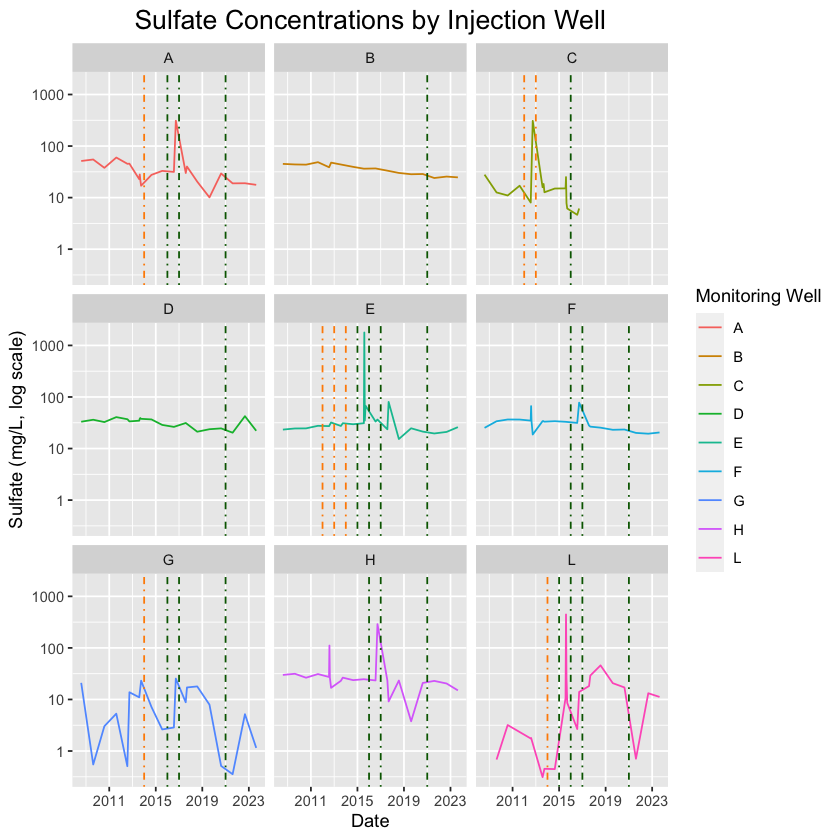

In [42]:
ggplot(sulfate_data2 %>% filter(MW %in% c("A", "B", "C", "D", "E", "F", "G", "H", "L")), 
       aes(Date, Sulfate, color = MW)) +
  geom_line(na.rm = TRUE) +
  scale_y_log10() +
  facet_wrap(~ MW) +
  geom_vline(aes(xintercept=as.numeric(as.Date(year))), 
             data = injdates, linetype=4, color = "darkgreen") +
  geom_vline(aes(xintercept=as.numeric(as.Date(year))), 
             data = pushpulldates, linetype=4, color = "darkorange") +
  labs(color = "Monitoring Well") +
  theme(legend.position = "right", plot.title = element_text(size = 16, hjust = 0.5)) +
  ggtitle("Sulfate Concentrations by Injection Well") + 
  ylab("Sulfate (mg/L, log scale)") +
  scale_x_date(date_breaks = "4 years", date_labels = "%Y") 

Sulfate concentrations by pad-edge well:

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


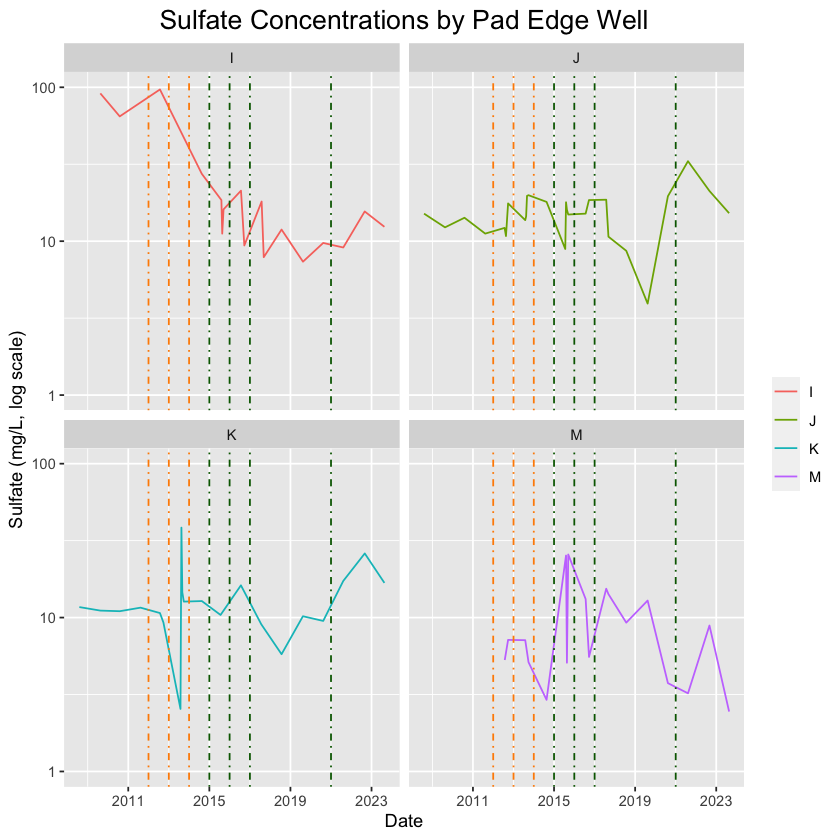

In [43]:
ggplot(sulfate_data2 %>% filter(MW %in% c("I", "J", "K", "M")), 
       aes(Date, Sulfate, color = MW)) +
  geom_line(na.rm = TRUE) +
  scale_y_log10(breaks = c(1, 10, 100), limits = c(1,1e2)) +
  facet_wrap(~ MW) +
  xlim(as.Date(c('1/1/2008', '9/9/2023'), format="%d/%m/%Y")) +
  geom_vline(aes(xintercept=as.numeric(as.Date(inj_date))), 
             data = injdatesonly, linetype=4, color = "darkgreen") +
  geom_vline(aes(xintercept=as.numeric(as.Date(push_date))), 
             data = pushpulldatesonly, linetype=4, color = "darkorange") +
  theme(legend.position = "right", legend.direction = "vertical", legend.key.size = unit(0.6, 'cm'),
        legend.title.align = 0.5, legend.title = element_blank(),
        plot.title = element_text(size = 16, hjust = 0.5)) +
  labs(color = "Monitoring Well") +
  ggtitle("Sulfate Concentrations by Pad Edge Well") + 
  ylab("Sulfate (mg/L, log scale)") +
  guides(color = guide_legend(nrow = 4)) +
  scale_x_date(date_breaks = "4 years", date_labels = "%Y") 